In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.stats import chisquare
import matplotlib.pyplot as plt
# from sklearn.metrics import confusion_matrix
from tkinter import filedialog
import math

In [2]:
# #bring data file 
# datafile=filedialog.askopenfilename()
# print(datafile)

In [3]:
# import data
# dff=pd.read_csv(datafile,header=0)
dff=pd.read_csv("D:/Thakur/Hawkes_data/1687_hawkes_data.csv",header=0)
print(dff.isnull().values.any()) # check wheather any nan number
print(dff.head(2)), print(dff.describe())

False
   Count   Time  aspect_kor          Y           X     D_Resi.  D_CattleF.  \
0      1  43740      169.88  38.264194  127.077194   660.68146  6918.82227   
1      2  43749      198.43  38.091369  126.938628  1860.24194  1895.94299   

     D_Water     Slope      D_Road  Aspect (cls)  Altitude        Date  
0  108.16654  10.28732  6300.28564             5       179   10/2/2019  
1  408.04413  12.57811  2202.90723             5       101  10/11/2019  
             Count          Time   aspect_kor            Y            X  \
count  1687.000000   1687.000000  1687.000000  1687.000000  1687.000000   
mean    844.000000  44122.542976   183.268216    38.030634   127.585567   
std     487.139268    207.046462    89.118143     0.186875     0.523734   
min       1.000000  43740.000000    -1.000000    37.119944   126.711692   
25%     422.500000  43912.000000   126.785000    37.954869   127.117727   
50%     844.000000  44169.000000   183.010000    38.074785   127.630083   
75%    1265.500

(None, None)

In [4]:
# lets measure the distances
avr_dist=[]
for i in range(0, len(dff)-1):# range(6*k,6*(k+1)):
    if not (dff['X'][i],dff['Y'][i])== (dff['X'][i+1],dff['Y'][i+1]):
        dis=math.acos(math.cos(math.radians(90-dff['Y'][i]))*math.cos(math.radians(90-dff['Y'][i+1]))\
          +math.sin(math.radians(90-dff['Y'][i])) *math.sin(math.radians(90-dff['Y'][i+1]))\
              *math.cos(math.radians( dff['X'][i]-dff['X'][i+1] ))) *6371
    else:
        dist=0
    avr_dist.append(dis)
print(np.mean(avr_dist))
# print(avr_dist)

32.231137044220176


In [5]:
# lets spilt the data to train test
x=dff.iloc[:,1:5].values
y=dff.iloc[:,0].values
X_train, X_test, y_train, y_test = train_test_split(
    x,y, test_size=0.33, random_state=42)

np.shape(X_train),np.shape(X_test), np.shape(y_train), np.shape(y_test)

((1130, 4), (557, 4), (1130,), (557,))

In [6]:
# # using train test sample
# t=np.array(X_train[:,0])
# y=np.array(X_train[:,2])
# x=np.array(X_train[:,3])
# y=np.array(y_train)

# without train test sample
t=np.array(dff.iloc[:,1])
y=np.array(dff.iloc[:,3])
x=np.array(dff.iloc[:,4])
Opt=np.array(dff.iloc[:,0])
# spilting the sequential data for traning 

# t=np.array(dff.iloc[:1000,1])
# y=np.array(dff.iloc[:1000,3])
# x=np.array(dff.iloc[:1000,4])
# Opt=np.array(dff.iloc[:1000,0])

#testing samples 
tt=np.array(dff.iloc[1000:,1])
yy=np.array(dff.iloc[1000:,3])
xx=np.array(dff.iloc[1000:,4])
Optt=np.array(dff.iloc[1000:,0])

# Hawkes equation

$$ lamda = (1-p)u(x,y)+ (p*q*b)/\pi* \sum\limits _{i=t_i <t} exp(-q(t-t_i)-b((x-x_i)^2+(y-y_i)^2))) $$

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

def func(X, p, a, b):
    t,x,y = X
    A=np.zeros(len(t))
    for i in range(1,len(t)):
        A[i]= np.exp(-a*(t[i]-t[i-1])\
                                   -b*((x[i]-x[i-1])**2+(y[i]-y[i-1])**2))+ A[i-1]
    # f_logsum=np.sum(np.log(p+(p*q*b/math.pi)*A))
#     lamda=(1-p)+((p)*a*b/math.pi)*np.cumsum(A)
    lamda=(1-p)+((p)*a*b/math.pi)*A
    return lamda

[9.85978980e-01 9.99886192e+01 4.46988467e-02] [[ 1.44944501e+00 -2.32025068e+02  3.83656991e-02]
 [-2.32025068e+02  5.06093155e+04 -1.22082819e+01]
 [ 3.83656991e-02 -1.22082819e+01  3.74851177e-03]]


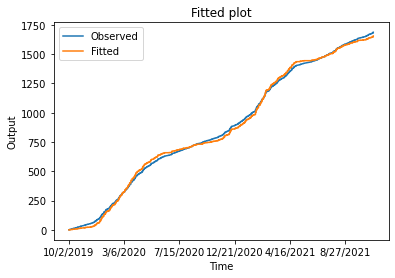

Text(0.5, 1.0, 'Corelation of cof. plot')

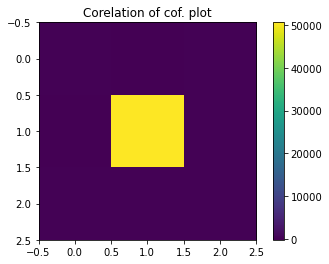

In [8]:
date=dff['Date'][0:len(t)]
popt, pcov = curve_fit(func,(t,y,x),Opt,bounds=(0,[1,100,100]))
# np.shape(t),np.shape(y),np.shape(x)
print(popt,pcov)
p,a,b=popt
plt.plot(date,Opt,label='Observed')
M=func((t,x,y),p,a,b)
plt.plot(date,M,label='Fitted')
plt.title('Fitted plot')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.xticks(np.arange(0,500,90))
plt.show()

plt.imshow(pcov);plt.colorbar()
plt.title('Corelation of cof. plot')

In [9]:
# find the R-square value between model value and ASF cases 
Y_model=np.array(M.astype(int))
y_obj=np.array(Opt.astype(int))
corr_matrix = np.corrcoef(y_obj, Y_model)
corr = corr_matrix[0,1]
R_sq = corr**2
print(f'The R-square value from numpy model between model and observed data is {round(R_sq,4)}')

The R-square value from numpy model between model and observed data is 0.9982


In [10]:
from sklearn.metrics import r2_score
R_sq=r2_score(y_obj, Y_model)
print(f'The R-square value from sklearn model between model and observed data is {round(R_sq,4)}')

The R-square value from sklearn model between model and observed data is 0.9981


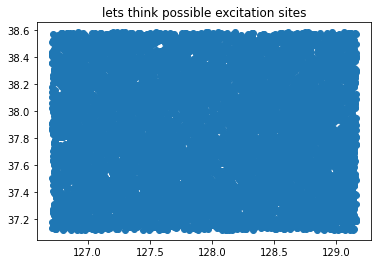

In [11]:
#Predicted time and new coordinates 
np.random.seed(0)
t0,x0,y0,opt0=t[-1],x[-1],y[-1],Opt[-1]
tp=[]
for tt in range(1,301):    # lets predict for 100 days ahead
    tp.append(t[-1]+tt)
# xp=np.arange(min(x),max(x),10)    
xp=np.random.choice(np.arange(min(x),max(x),0.00005)  ,10000,replace=False)  # 10000 random x points betn min and max of x
yp=np.random.choice(np.arange(min(y),max(y),0.00005)  ,10000,replace=False) 

plt.scatter(xp,yp)
plt.title('lets think possible excitation sites')
Time=[t0];x_cord=[x0];y_cord=[y0];cnt=[opt0] # simulatiion time, coordinates and cnt as counts 

In [12]:
print(t0,x0,y0,opt0, Time,cnt[-1],x_cord,y_cord)
print(tp[0],Time[-1])

44506 128.657591 37.119982 1687 [44506] 1687 [128.657591] [37.119982]
44507 44506


In [37]:
Time[-1],tp[0], p,a,b


(44506, 44507, 0.9859789797172989, 99.98861916789257, 0.04469884670819555)

In [14]:
# cntt=[1687]
# for j in range(10):
# #     print(tp[j],Time[-1]) 
#     cnt=[1687]
#     for i in range(1500):
# #         cnt[-1]=(1-p)+(np.exp(-a*(tp[j]-Time[-1])\
# #                                    -b*((xp[i]-x_cord[-1])**2+(yp[i]-y_cord[-1])**2)))*((p*a*b/math.pi))+ cnt[-1]
#         cnt[-1]=(np.exp(-a*(tp[j]-Time[-1])\
#                                    -b*((xp[i]-x_cord[-1])**2+(yp[i]-y_cord[-1])**2)))*((p*a*b/math.pi))+ cnt[-1]
#         cnt.append(cnt[-1])
#         if cnt[-1]>1687:
#             print(cnt[-1])
        
        

In [54]:
(np.exp(-a*(0)-b*((127 -x_cord[-1])**2+(37-y_cord[-1])**2)))*((p*a*b/math.pi))

1.239787864415213

In [57]:
cntt=[1687]    # current infected numbers 
for itrn in range(10):     # lets check for next 10 dayss 
    for tm in  tp:  # check for each time period
        for xt,yt in zip(xp,yp):
            extn=(np.exp(-a*(tm-Time[-1])\
                                   -b*((xt-x_cord[-1])**2+(yt-y_cord[-1])**2)))*((p*a*b/math.pi))
            if np.round(extn)>=1:
                print(extn,tm, xt, yt)

In [ ]:
# question what happened if 2 outbreaks present once at a time in a same point 
# assumption is outbreak once at a point in particular time 
# def predict_time_n_cord(X, p, a, b,t0,x0,y0,opt0):   # (x) time, coordiinates, (p,a,b) constants, predict_start_time, opt0: current outbreak number 
# t,x,y = X

Time=[t0];x_cord=[x0];y_cord=[y0];count=[opt0]

for j in range(5):
    print(tp[j],Time[-1])
    for i in range(0,10):
#         excitation =(1-p)+(p*a*b/math.pi)*(np.exp((-a*(t[j]-time[-1])\
#                                -b*((x[i]-x_cord[-1])**2+(y[i]-y_cord[-1])**2))))#+count[-1]) #A[i-1]   # cumulatinve value is not considered 
#         excitation =(1-p)+(p*a*b/math.pi)*(np.exp(-a*(tp[j]-time[-1])\
#                                         -b*((xp[i]-x_cord[-1])**2+(yp[i]-y_cord[-1])**2)))\
#                                         + count[-1]/(1-p)+(p*a*b/math.pi)
        excitation =(np.exp(-a*(tp[j]-Time[-1])\
                                        -b*((xp[i]-x_cord[-1])**2+(yp[i]-y_cord[-1])**2)))+count[-1]
#         excitation =(p*a*b/math.pi)*(np.exp(-a*(tp[j]-time[-1])\
#                                                   -b*((xp[i]-x_cord[-1])**2+(yp[i]-y_cord[-1])**2)))
#         excitation =(np.exp(-a*(tp[j]-time[-1])\
#                                                   -b*((xp[i]-x_cord[-1])**2+(yp[i]-y_cord[-1])**2)))
#         print(excitation,xp[i])
        count.append(count[-1]+1)
        
    Time.append(tp[j])
#         if (round(excitation)-count[-1])>=1:
# #         if excitation>1:
#             print(tp[j],count[-1],time[-1])
#             print('done')
# #             print(excitation,tp[j],xp[i],yp[i])
#             time.append(tp[j])
#             x_cord.append(xp[i])
#             y_cord.append(yp[i])
#             count.append(count[-1]+1)
#             print('what is happening ')
 
    # f_logsum=np.sum(np.log(p+(p*q*b/math.pi)*A))
#     lamda=(1-p)+((p)*a*b/math.pi)*A
#     return lamda

In [ ]:
##################################### ALL together ########################
# setting the new function with new approach 
def func(X, p, a, b):
    t,x,y = X
    A=[0]
    for i in range(1,len(t)):
        xxx=(np.exp((-a*(t[i]-t[i-1])\
                                   -b*((x[i]-x[i-1])**2+(y[i]-y[i-1])**2))))+A[i-1]
        A.append(xxx)
        lamda=(1-p)+(p*a*b/math.pi)*np.array(A)
    return lamda
popt, pcov = curve_fit(func,(t,y,x),Opt,bounds=(0,[1,100,100]))
p,a,b=popt
print(popt)
M=func((t,x,y),p,a,b)
p,a,b=popt
plt.plot(date,Opt,label='Observed')
M=func((t,x,y),p,a,b)    # lets check first 1000 items
plt.plot(date,M,label='Fitted')        # lets plot first 1000 items
plt.title('Fitted plot')
plt.xlabel('Time')
plt.ylabel('Output')
plt.legend()
plt.xticks(np.arange(0,500,90))
plt.show()
# find the R-square value between model value and ASF cases 
Y_model=np.array(M)
y_obj=np.array(Opt.astype(int))
corr_matrix = np.corrcoef(y_obj, Y_model)
corr = corr_matrix[0,1]
R_sq = corr**2
print(f'The R-square value from numpy model between model and observed data is {round(R_sq,4)}')


In [ ]:
#lets, check only for first 1000 data
t[:1000];y[:1000];x[:1000]
popt, pcov = curve_fit(func,(t,y,x),Opt,bounds=(0,[1,100,100]))
popt

In [ ]:
M=func((t[:1000],x[:1000],y[:1000]),p,a,b)    # lets check first 1000 items
plt.plot(date[:1000],M,label='Fitted')        # lets plot first 1000 items
plt.plot(date[:1000],Opt[:1000],label='Observed')

plt.xticks(np.arange(0,500,90))
plt.show()

In [ ]:
M[:20]*(p*a*b/math.pi)+10

In [ ]:
p,a,b=popt
def func(X, p, a, b):
    t,x,y = X
    A=np.zeros(len(t))
    for i in range(1,len(t)):
        A[i-1]= np.exp((-a*(t[i]-t[i-1])\
                                   -b*((x[i]-x[i-1])**2+(y[i]-y[i-1])**2)))+A[i-1]
        
#         print(round(A[i-1]))
    # f_logsum=np.sum(np.log(p+(p*q*b/math.pi)*A))
#     lamda=(1-p)+((p)*a*b/math.pi)*np.cumsum(A)  #if saved as A[i-1]
    lamda=(1-p)+((p)*a*b/math.pi)*(A) #if saved as A[i]
    lamda.astype(int)
    print(np.sum(A),len(A))
    plt.plot(A[:10])
    plt.show()
    print((A[:10]))
    return lamda
M=func((t,x,y),p,a,b)
print(max(M))

In [ ]:
plt.plot(M)
print(max(M),min(M))

In [ ]:
plt.plot(func((tp,xp,yp),p,a,b))